In [81]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [82]:
# Load the 10 folds into a list of DataFrames
datasets = [pd.read_csv(f"datasets/sound_features_fold{i}.csv") for i in range(1, 11)]

# Define the mapping of labels to numbers
labels_dict = {
    "air_conditioner": 0,
    "car_horn": 1,
    "children_playing": 2,
    "dog_bark": 3,
    "drilling": 4,
    "engine_idling": 5,
    "gun_shot": 6,
    "jackhammer": 7,
    "siren": 8,
    "street_music": 9
}
# Replace string labels with numeric labels in each fold DataFrame
for df in datasets:
    df["Label"] = df["Label"].replace(labels_dict)

# Check the updated labels in the first fold
datasets[0].head()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_rolloff,spectral_flatness,rms,zero_crossing_rate,tempo,tempogram,Label
0,-374.44590,97.047250,9.259301,-17.928537,1.152152,-8.538063,-15.637719,-8.188658,-11.003868,1.985415,...,960.279319,1313.641864,22.421554,1763.516865,0.003240,0.079418,0.050405,[66.96428571],0.040491,3
1,-333.74377,133.216250,15.807837,-33.060143,-1.289476,-17.097427,-30.018026,-22.263353,-18.194607,4.316967,...,865.872849,1143.308567,23.852010,1420.634921,0.001789,0.087223,0.053943,[110.29411765],0.059969,3
2,-382.80362,68.959465,4.313661,-2.062933,3.721442,-5.117520,-8.518147,-1.823458,-4.410032,4.914453,...,1132.635828,1453.488132,21.033922,2213.789683,0.009837,0.052242,0.059059,[52.08333333],0.031151,3
3,-96.21553,87.579865,-52.939266,-5.229744,-16.976635,3.661066,-4.204170,10.106073,3.249916,10.754143,...,1801.149302,1495.233043,21.253521,3214.285714,0.039912,0.118702,0.158978,[170.45454545],0.115612,3
4,-217.80743,124.950710,21.462078,11.288554,-10.218013,0.942786,-1.060578,7.175950,0.728432,1.115492,...,1163.692856,1572.547755,20.424197,2396.515377,0.015071,0.070206,0.071091,[133.92857143],0.025050,6


In [83]:
for df in datasets:
    object_columns = df.select_dtypes(include=['object']).columns
    print(object_columns)

Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')
Index(['tempo'], dtype='object')


In [84]:
# Example: Check what type of obejct 'tempo' is
print(datasets[0]['tempo'].head())

0     [66.96428571]
1    [110.29411765]
2     [52.08333333]
3    [170.45454545]
4    [133.92857143]
Name: tempo, dtype: object


In [85]:
import ast  # For safely evaluating the string representation of lists

for df in datasets:
    # Convert the string representation of lists to actual lists
    df['tempo'] = df['tempo'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Now, extract the first value from the list (if it’s a list)
    df['tempo'] = df['tempo'].apply(lambda x: x[0] if isinstance(x, list) else x)

    # Convert the 'tempo' column to numeric
    df['tempo'] = pd.to_numeric(df['tempo'], errors='coerce')

    # Check for NaN values
    print(df['tempo'].isna().sum())  # Count of NaN values

    # Handle NaN values (optional)
    df['tempo'].fillna(df['tempo'].mean(), inplace=True)  # Fill NaNs with the mean
    # Alternatively, you could drop rows with NaNs: df.dropna(subset=['tempo'], inplace=True)
datasets[0].head()

0
0
0
0
0
0
0
0
0
0


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_rolloff,spectral_flatness,rms,zero_crossing_rate,tempo,tempogram,Label
0,-374.44590,97.047250,9.259301,-17.928537,1.152152,-8.538063,-15.637719,-8.188658,-11.003868,1.985415,...,960.279319,1313.641864,22.421554,1763.516865,0.003240,0.079418,0.050405,66.964286,0.040491,3
1,-333.74377,133.216250,15.807837,-33.060143,-1.289476,-17.097427,-30.018026,-22.263353,-18.194607,4.316967,...,865.872849,1143.308567,23.852010,1420.634921,0.001789,0.087223,0.053943,110.294118,0.059969,3
2,-382.80362,68.959465,4.313661,-2.062933,3.721442,-5.117520,-8.518147,-1.823458,-4.410032,4.914453,...,1132.635828,1453.488132,21.033922,2213.789683,0.009837,0.052242,0.059059,52.083333,0.031151,3
3,-96.21553,87.579865,-52.939266,-5.229744,-16.976635,3.661066,-4.204170,10.106073,3.249916,10.754143,...,1801.149302,1495.233043,21.253521,3214.285714,0.039912,0.118702,0.158978,170.454545,0.115612,3
4,-217.80743,124.950710,21.462078,11.288554,-10.218013,0.942786,-1.060578,7.175950,0.728432,1.115492,...,1163.692856,1572.547755,20.424197,2396.515377,0.015071,0.070206,0.071091,133.928571,0.025050,6


In [86]:
for df in datasets:
    object_columns = df.select_dtypes(include=['object']).columns
    print(object_columns)

Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')


In [87]:
def reshape_for_cnn(data, n_features):
    # Redimensionar os dados para (amostras, altura=1, largura=n_features, canais=1)
    return data.reshape(data.shape[0], 1, n_features, 1)


In [88]:
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))  # 10 classes

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [89]:
def generatefolds_plots(test_fold,history,conf_matrix):
    # Generate per-fold plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Fold {test_fold} Performance", fontsize=16)

    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label="Train", color="blue")
    axes[0].plot(history.history['val_accuracy'], label="Validation", color="orange")
    axes[0].set_title("Model Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()

    # Plot loss
    axes[1].plot(history.history['loss'], label="Train", color="blue")
    axes[1].plot(history.history['val_loss'], label="Validation", color="orange")
    axes[1].set_title("Model Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    # Plot confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[2])
    axes[2].set_title("Confusion Matrix")
    axes[2].set_xlabel("Predicted Label")
    axes[2].set_ylabel("True Label")

    # Adjust layout and save/show the plot
    plt.tight_layout()
    plt.savefig(f"fold{test_fold}_performance.png")  # Save the plot if needed
    plt.show()


Processing Fold 1...


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.2283 - loss: 2.1240 - val_accuracy: 0.4200 - val_loss: 1.6287 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4906 - loss: 1.4645 - val_accuracy: 0.5101 - val_loss: 1.4732 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5614 - loss: 1.2656 - val_accuracy: 0.5372 - val_loss: 1.4034 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6181 - loss: 1.1329 - val_accuracy: 0.5518 - val_loss: 1.3703 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6547 - loss: 1.0276 - val_accuracy: 0.5248 - val_loss: 1.3625 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6804 - loss: 0.9619 - val_accuracy: 0.5552 - val_loss: 1.4044 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7030 - loss: 0.8980 - val_accurac

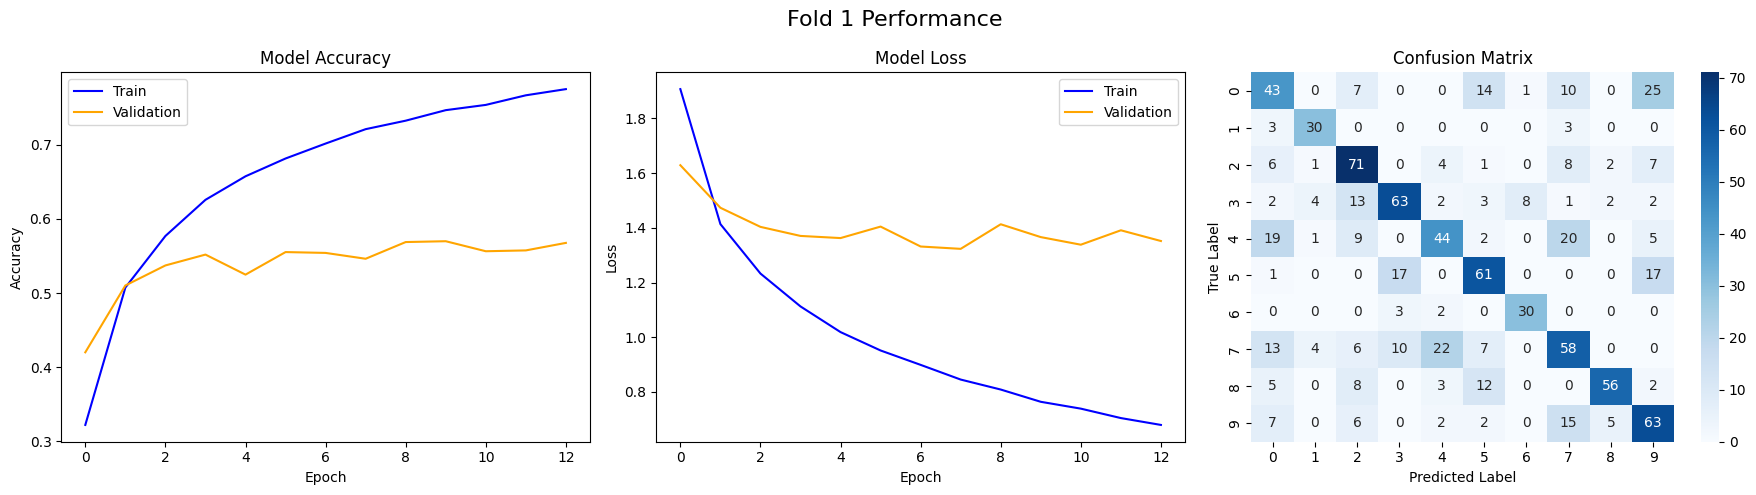

Fold 1: Test accuracy: 0.5945
Processing Fold 2...
Epoch 1/50


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2448 - loss: 2.1085 - val_accuracy: 0.3546 - val_loss: 1.6952 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4934 - loss: 1.4794 - val_accuracy: 0.4011 - val_loss: 1.5819 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5789 - loss: 1.2457 - val_accuracy: 0.4346 - val_loss: 1.5183 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6257 - loss: 1.1050 - val_accuracy: 0.4443 - val_loss: 1.5409 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6561 - loss: 1.0147 - val_accuracy: 0.4595 - val_loss: 1.5321 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6887 - loss: 0.9612 - val_accuracy: 0.4573 - val_loss: 1.5705 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7087 - loss: 0.8926 - val_accuracy: 0.4714 - v

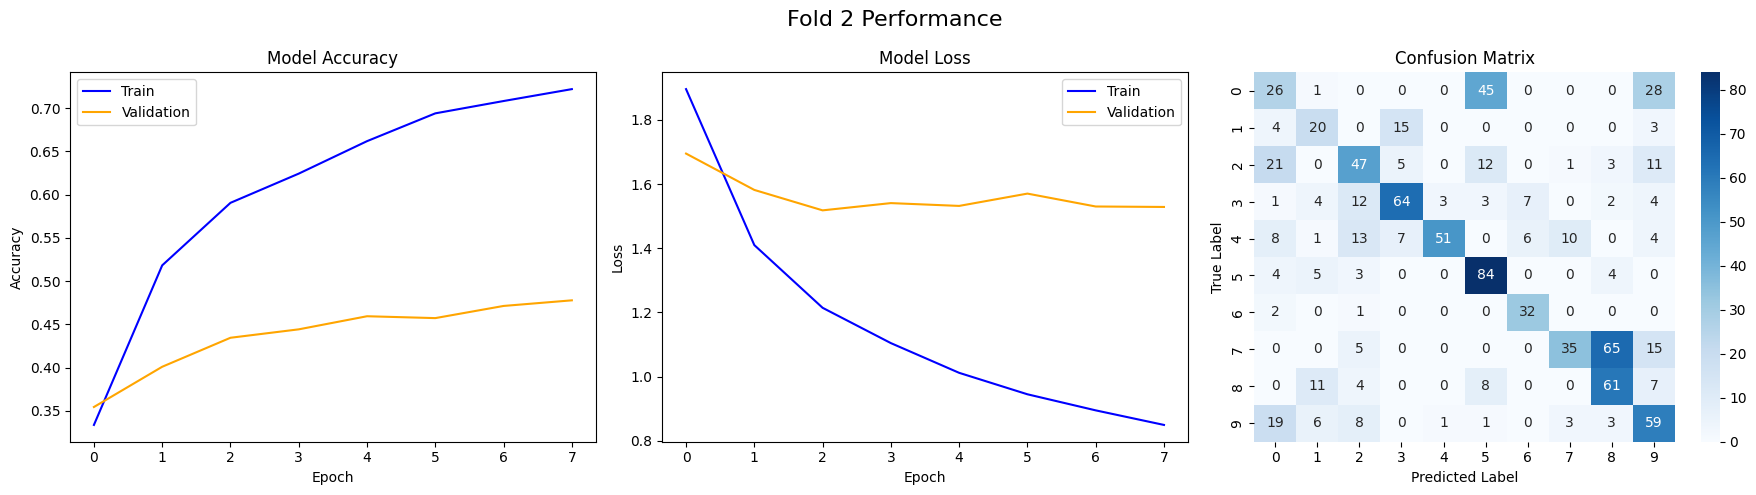

Fold 2: Test accuracy: 0.5394
Processing Fold 3...
Epoch 1/50


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2386 - loss: 2.1255 - val_accuracy: 0.3818 - val_loss: 1.7744 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4929 - loss: 1.4820 - val_accuracy: 0.4566 - val_loss: 1.5416 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5594 - loss: 1.2868 - val_accuracy: 0.4869 - val_loss: 1.4181 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6271 - loss: 1.1267 - val_accuracy: 0.5273 - val_loss: 1.3592 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6473 - loss: 1.0481 - val_accuracy: 0.5404 - val_loss: 1.3150 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6828 - loss: 0.9480 - val_accuracy: 0.5525 - val_loss: 1.2655 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7012 - loss: 0.8888 - val_accuracy: 0.5758 - v

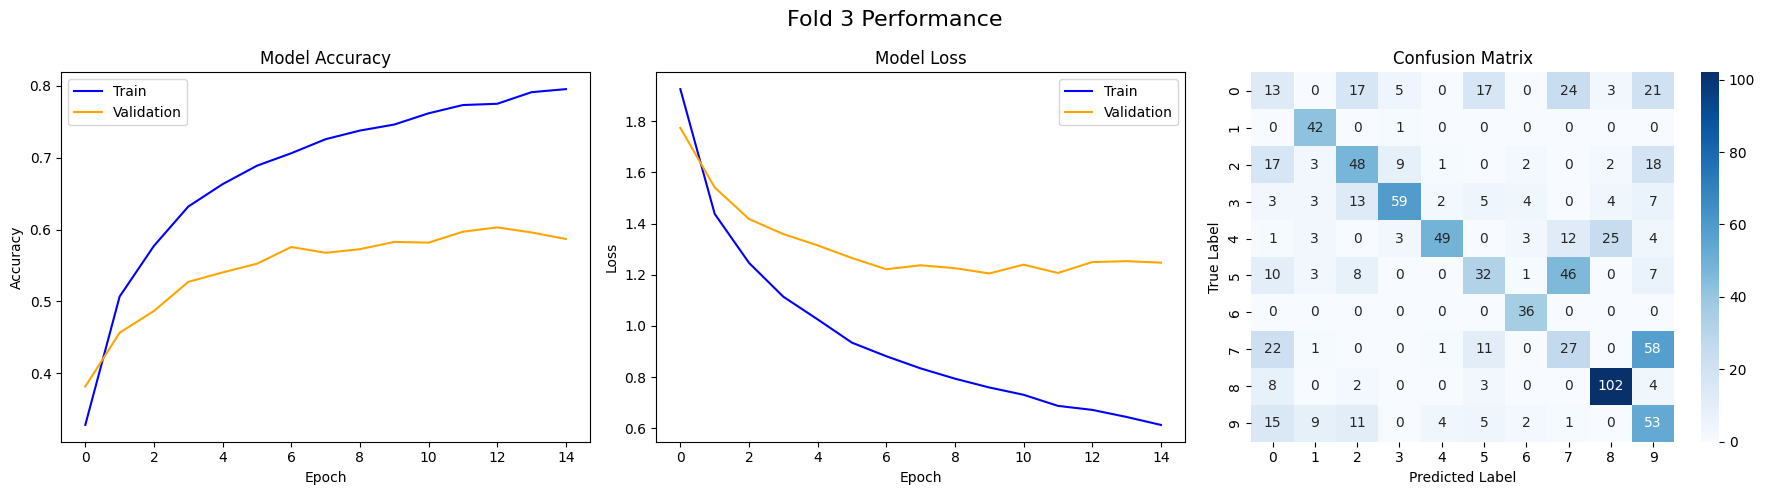

Fold 3: Test accuracy: 0.4984
Processing Fold 4...
Epoch 1/50


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2383 - loss: 2.1009 - val_accuracy: 0.5246 - val_loss: 1.4795 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4961 - loss: 1.4605 - val_accuracy: 0.4904 - val_loss: 1.3389 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5640 - loss: 1.2675 - val_accuracy: 0.6143 - val_loss: 1.2004 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6347 - loss: 1.0918 - val_accuracy: 0.6314 - val_loss: 1.1476 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6617 - loss: 1.0130 - val_accuracy: 0.6143 - val_loss: 1.1408 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6789 - loss: 0.9537 - val_accuracy: 0.6506 - val_loss: 1.0664 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6966 - loss: 0.9024 - val_accuracy: 0.6453 - v

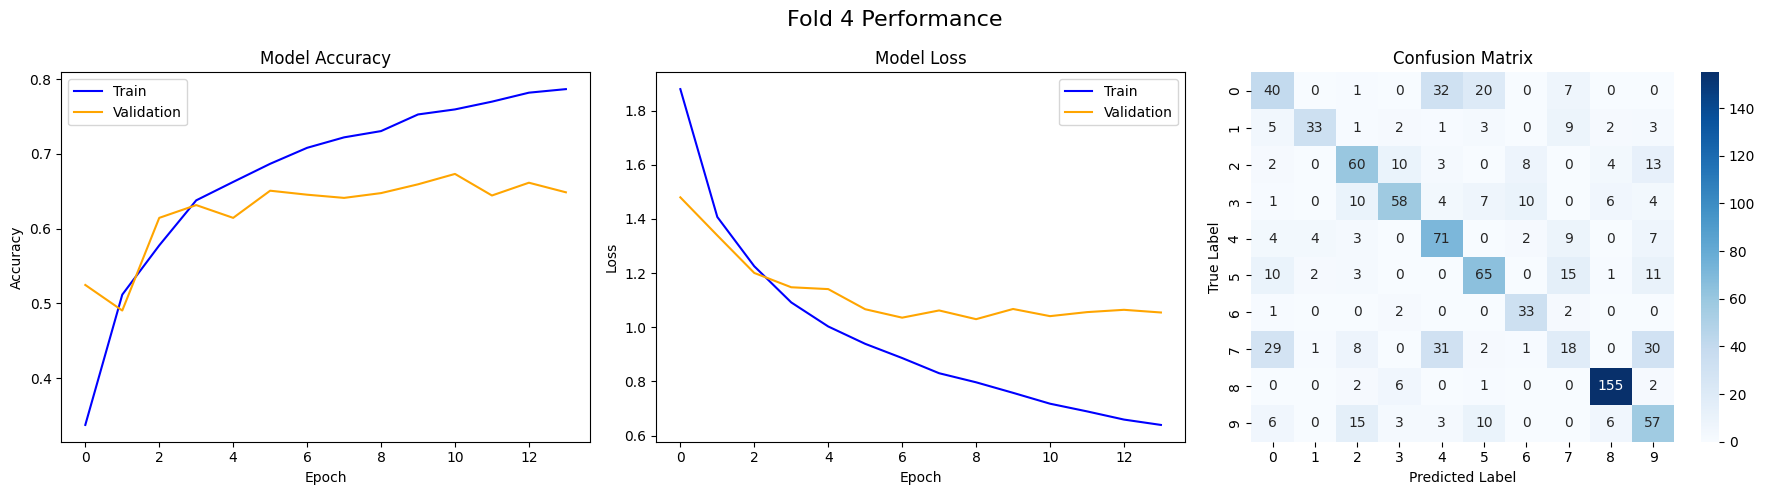

Fold 4: Test accuracy: 0.5960
Processing Fold 5...
Epoch 1/50


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2306 - loss: 2.1166 - val_accuracy: 0.3888 - val_loss: 1.6807 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4884 - loss: 1.4922 - val_accuracy: 0.4605 - val_loss: 1.5121 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5568 - loss: 1.2721 - val_accuracy: 0.4897 - val_loss: 1.4437 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6142 - loss: 1.1351 - val_accuracy: 0.5091 - val_loss: 1.4466 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6532 - loss: 1.0378 - val_accuracy: 0.5006 - val_loss: 1.3963 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6804 - loss: 0.9738 - val_accuracy: 0.5273 - val_loss: 1.3686 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7062 - loss: 0.9055 - val_accuracy: 0.5079 

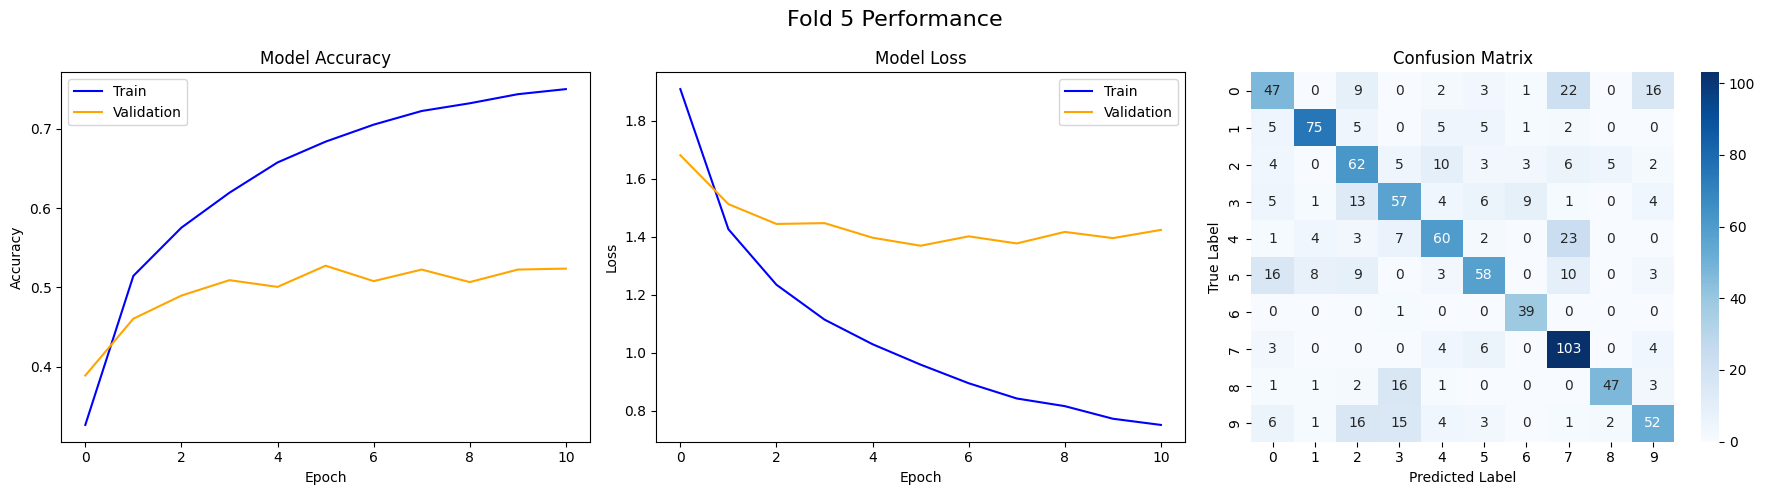

Fold 5: Test accuracy: 0.6410
Processing Fold 6...
Epoch 1/50


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.2591 - loss: 2.0687 - val_accuracy: 0.4129 - val_loss: 1.6480 - learning_rate: 0.0010
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5101 - loss: 1.4267 - val_accuracy: 0.4976 - val_loss: 1.4468 - learning_rate: 0.0010
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5853 - loss: 1.2168 - val_accuracy: 0.5585 - val_loss: 1.3387 - learning_rate: 0.0010
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6353 - loss: 1.0796 - val_accuracy: 0.5549 - val_loss: 1.2529 - learning_rate: 0.0010
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6673 - loss: 1.0027 - val_accuracy: 0.5776 - val_loss: 1.2252 - learning_rate: 0.0010
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6975 - loss: 0.9304 - val_accuracy: 0.5501 - val_loss: 1.2264 - learning_rate: 0.0010
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7155 - loss: 0.8679 - val_accuracy: 0.5668

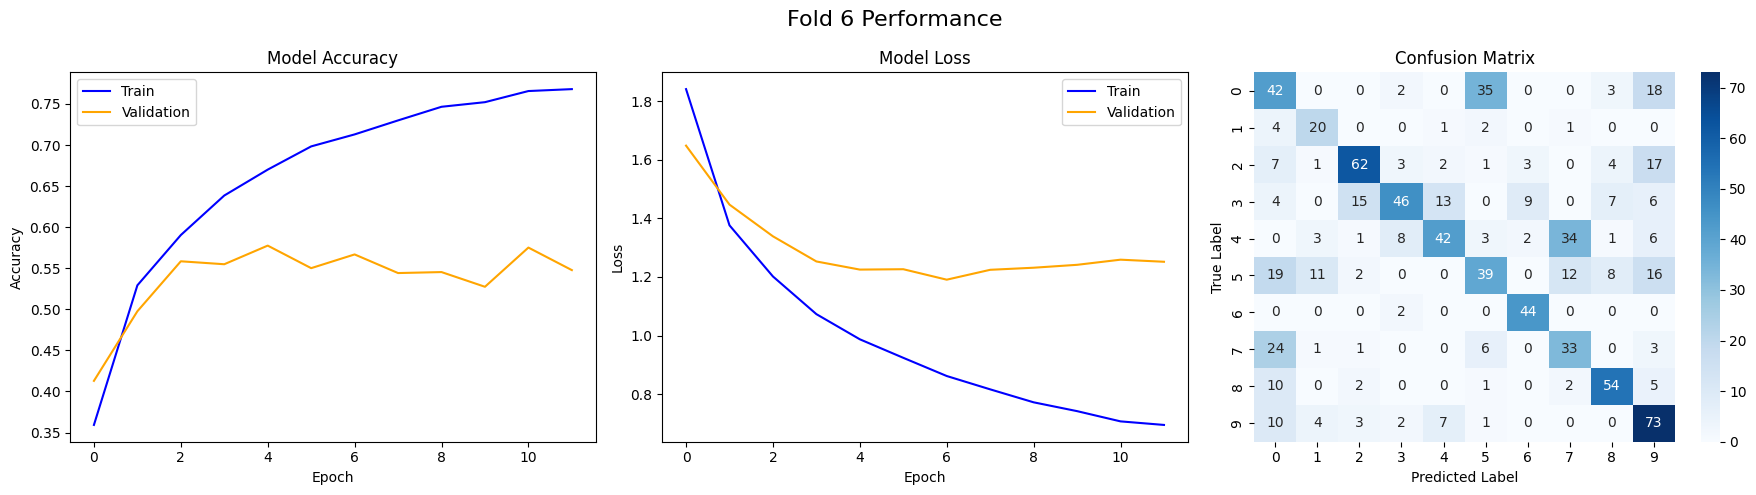

Fold 6: Test accuracy: 0.5529
Processing Fold 7...
Epoch 1/50


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2322 - loss: 2.1170 - val_accuracy: 0.4963 - val_loss: 1.4502 - learning_rate: 0.0010
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4790 - loss: 1.4926 - val_accuracy: 0.5720 - val_loss: 1.2623 - learning_rate: 0.0010
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5697 - loss: 1.2784 - val_accuracy: 0.5868 - val_loss: 1.1749 - learning_rate: 0.0010
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6264 - loss: 1.1358 - val_accuracy: 0.6241 - val_loss: 1.1229 - learning_rate: 0.0010
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6599 - loss: 1.0199 - val_accuracy: 0.6278 - val_loss: 1.1076 - learning_rate: 0.0010
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6807 - loss: 0.9635 - val_accuracy: 0.5893 - val_loss: 1.1322 - learning_rate: 0.0010
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7133 - loss: 0.8714 - val_accuracy: 0.6340 - 

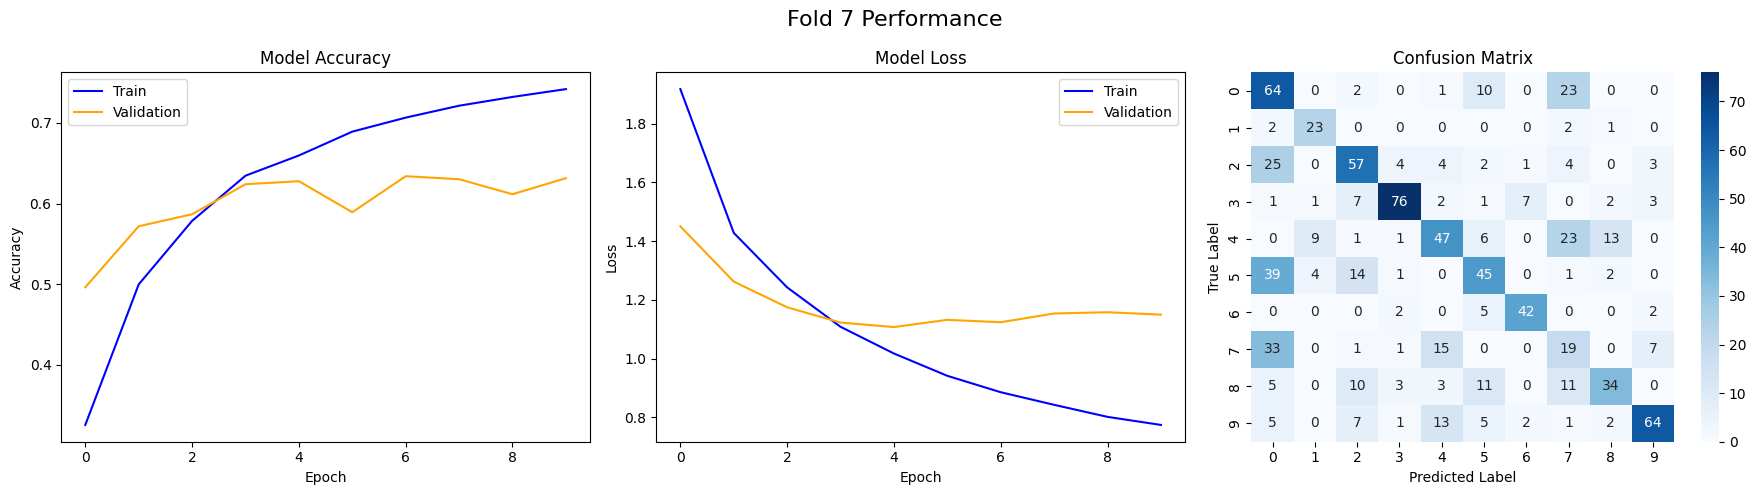

Fold 7: Test accuracy: 0.5621
Processing Fold 8...
Epoch 1/50


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2601 - loss: 2.0787 - val_accuracy: 0.4694 - val_loss: 1.5738 - learning_rate: 0.0010
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4918 - loss: 1.4717 - val_accuracy: 0.5294 - val_loss: 1.4067 - learning_rate: 0.0010
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5682 - loss: 1.2604 - val_accuracy: 0.5539 - val_loss: 1.3298 - learning_rate: 0.0010
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6151 - loss: 1.1305 - val_accuracy: 0.6287 - val_loss: 1.2620 - learning_rate: 0.0010
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6712 - loss: 1.0118 - val_accuracy: 0.6201 - val_loss: 1.1726 - learning_rate: 0.0010
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6947 - loss: 0.9305 - val_accuracy: 0.6201 - val_loss: 1.1425 - learning_rate: 0.0010
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7212 - loss: 0.8441 - val_accuracy: 0.6201 - 

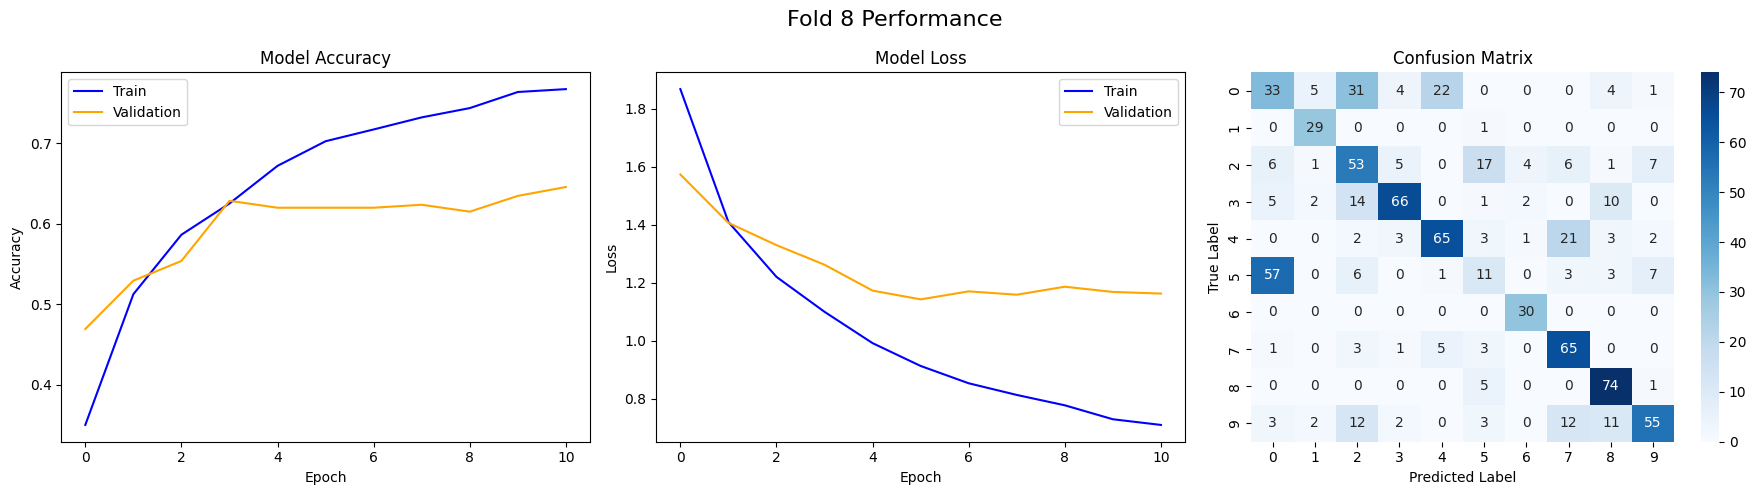

Fold 8: Test accuracy: 0.5968
Processing Fold 9...
Epoch 1/50


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2302 - loss: 2.1098 - val_accuracy: 0.5663 - val_loss: 1.4780 - learning_rate: 0.0010
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4982 - loss: 1.4652 - val_accuracy: 0.5627 - val_loss: 1.3350 - learning_rate: 0.0010
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5731 - loss: 1.2362 - val_accuracy: 0.5806 - val_loss: 1.2732 - learning_rate: 0.0010
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6274 - loss: 1.0951 - val_accuracy: 0.6022 - val_loss: 1.2091 - learning_rate: 0.0010
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6635 - loss: 1.0109 - val_accuracy: 0.6177 - val_loss: 1.1652 - learning_rate: 0.0010
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6914 - loss: 0.9290 - val_accuracy: 0.6356 - val_loss: 1.1284 - learning_rate: 0.0010
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6915 - loss: 0.9116 - val_accuracy: 0.6213 - v

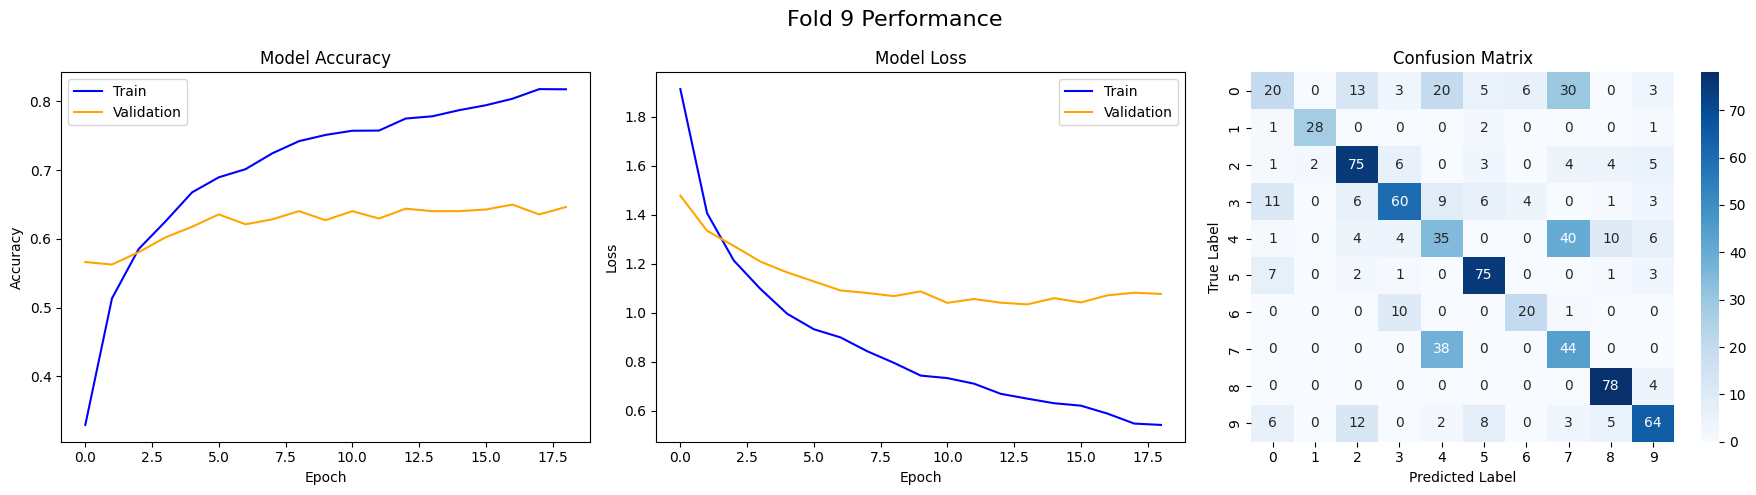

Fold 9: Test accuracy: 0.6115
Processing Fold 10...
Epoch 1/50


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2090 - loss: 2.1371 - val_accuracy: 0.4513 - val_loss: 1.7113 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4880 - loss: 1.4767 - val_accuracy: 0.5304 - val_loss: 1.5316 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5676 - loss: 1.2624 - val_accuracy: 0.5601 - val_loss: 1.5487 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6148 - loss: 1.1301 - val_accuracy: 0.5727 - val_loss: 1.5474 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6560 - loss: 1.0229 - val_accuracy: 0.5922 - val_loss: 1.5740 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6933 - loss: 0.9217 - val_accuracy: 0.5762 - val_loss: 1.5047 - learning_rate: 5.0000e-04
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7078 - loss: 0.8856 - val_accuracy: 0.576

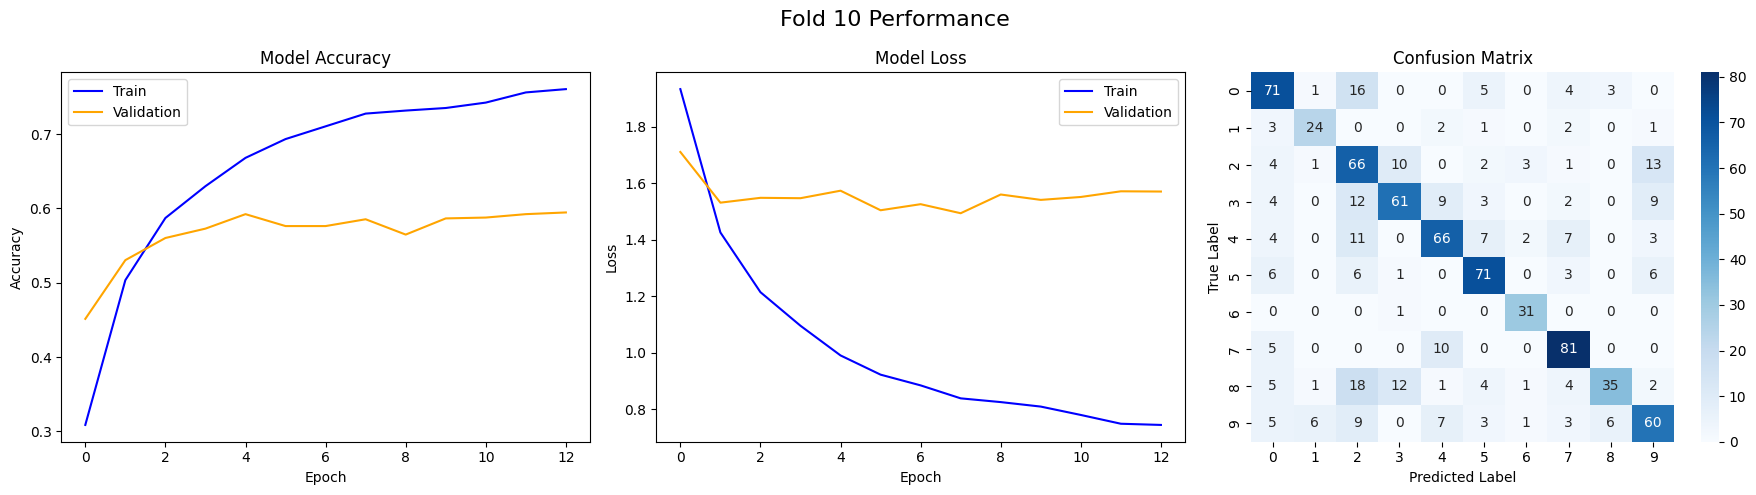

Fold 10: Test accuracy: 0.6762


In [90]:
all_y_true = []
all_y_pred = []
accuracies = []

for test_fold in range(1, 11):
    print(f"Processing Fold {test_fold}...")

    # Dividir os dados entre treino, validação e teste
    test_data = datasets[test_fold - 1]
    X_test = test_data.drop(columns=['Label']).values
    y_test = test_data['Label'].values

    val_fold = (test_fold % 10) + 1  # Fold para validação
    val_data = datasets[val_fold - 1]
    X_val = val_data.drop(columns=['Label']).values
    y_val = val_data['Label'].values

    train_data = pd.concat([datasets[i] for i in range(10) if i not in [test_fold - 1, val_fold - 1]])
    X_train = train_data.drop(columns=['Label']).values
    y_train = train_data['Label'].values

    # Aplicar SMOTE aos dados de treinamento
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Normalizar os dados
    scaler = StandardScaler()
    X_train_smote = scaler.fit_transform(X_train_smote)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Redimensionar os dados para (n_samples, altura=1, largura=n_features, canais=1)
    X_train_smote = X_train_smote.reshape(X_train_smote.shape[0], 1, X_train_smote.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], 1)

    # Criar e treinar o modelo
    input_shape = (1, X_train_smote.shape[2], 1)  # Alteração aqui para garantir a forma correta
    model = create_cnn_model(input_shape)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

    history = model.fit(
        x=X_train_smote,
        y=y_train_smote,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=128,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )

    # Fazer previsões
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Acumular valores reais e previstos
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred_classes)

    # Matriz de confusão para o fold atual
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Plotar os gráficos lado a lado
    generatefolds_plots(test_fold,history,conf_matrix)

    # Exibir a acurácia final do fold
    accuracy = accuracy_score(y_test, y_pred_classes)
    accuracies.append(accuracy)
    print(f"Fold {test_fold}: Test accuracy: {accuracy:.4f}")


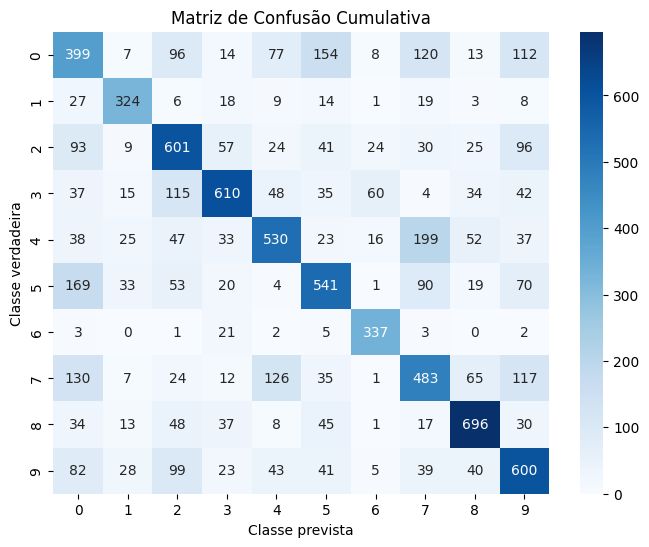

In [91]:
# Criar a matriz de confusão cumulativa após as 10 iterações
cumulative_conf_matrix = confusion_matrix(all_y_true, all_y_pred)

# Plotar a matriz de confusão cumulativa
plt.figure(figsize=(8, 6))
sns.heatmap(cumulative_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão Cumulativa')
plt.xlabel('Classe prevista')
plt.ylabel('Classe verdadeira')
plt.show()

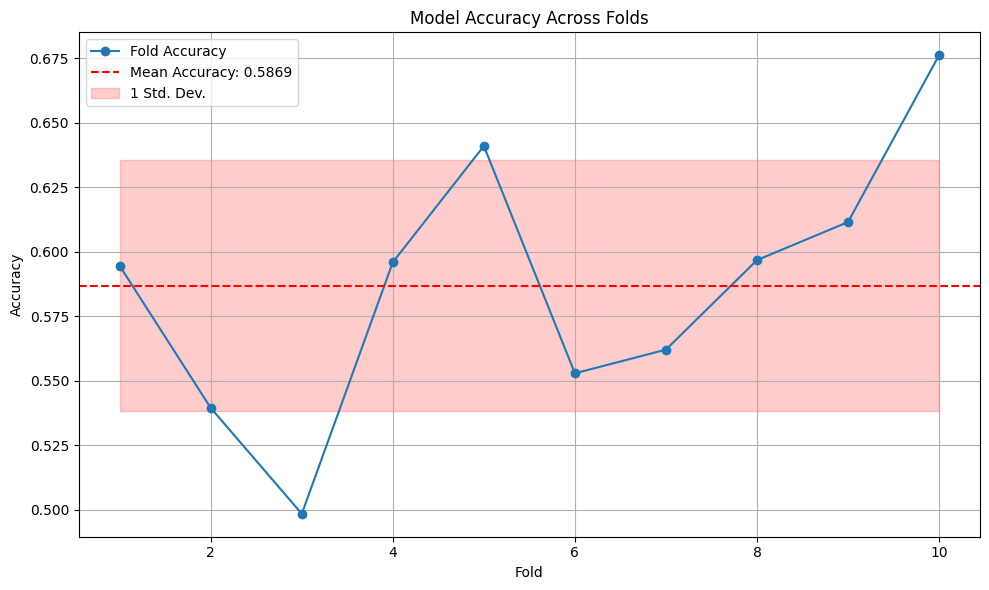

In [92]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), accuracies, marker='o', label='Fold Accuracy')
plt.axhline(np.mean(accuracies), color='r', linestyle='--', label=f'Mean Accuracy: {np.mean(accuracies):.4f}')
plt.fill_between(range(1, 11),
                 np.mean(accuracies) - np.std(accuracies),
                 np.mean(accuracies) + np.std(accuracies),
                 color='r', alpha=0.2, label='1 Std. Dev.')
plt.title("Model Accuracy Across Folds")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()